#AirBNB: Amsterdam Analysis story with interactive Maps

Interactive Folium maps, interactive plotly graphs, and text mining of the review comments

In [1]:
! pip install geopandas

     |████████████████████████████████| 1.0MB 5.4MB/s 
     |████████████████████████████████| 6.6MB 10.7MB/s 
     |████████████████████████████████| 15.4MB 165kB/s 


In [2]:
! pip install chart_studio

     |████████████████████████████████| 71kB 3.4MB/s 


In [3]:
! pip install nltk

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

**The listings and listing details files**

In [5]:
! unzip /content/Amsterdam_AirBNB.zip

Archive:  /content/Amsterdam_AirBNB.zip
  inflating: Amsterdam_AirBNB/calendar.csv  
  inflating: Amsterdam_AirBNB/listings.csv  
  inflating: Amsterdam_AirBNB/listings_details.csv  
  inflating: Amsterdam_AirBNB/neighbourhoods.csv  
  inflating: Amsterdam_AirBNB/neighbourhoods.geojson  
  inflating: Amsterdam_AirBNB/reviews.csv  
  inflating: Amsterdam_AirBNB/reviews_details.csv  


In [6]:
listings = pd.read_csv("/content/Amsterdam_AirBNB/listings.csv", index_col= "id")
listings_details = pd.read_csv("/content/Amsterdam_AirBNB/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("/content/Amsterdam_AirBNB/calendar.csv", parse_dates=['date'], index_col=['listing_id'])

reviews_details = pd.read_csv("/content/Amsterdam_AirBNB/reviews_details.csv", parse_dates=['date']) 

In [7]:
print(listings.shape)

(20030, 15)


The listings file contains 15 variables per listing besides the id.

In [8]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

The listings_details file contains a total of 96 variables. I am not going to use all of these, but selectively joined a number of variables that seemed useful to me for this EDA.

In [9]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 2818 to 30580413
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            19992 non-null  object 
 1   host_id                         20030 non-null  int64  
 2   host_name                       20026 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   20030 non-null  object 
 5   latitude                        20030 non-null  float64
 6   longitude                       20030 non-null  float64
 7   room_type                       20030 non-null  object 
 8   price                           20030 non-null  int64  
 9   minimum_nights                  20030 non-null  int64  
 10  number_of_reviews               20030 non-null  int64  
 11  last_review                     17624 non-null  object 
 12  reviews_per_month         

We see that neighbourhood_group is useless in Amsterdam, as it contains zero non-null objects. Below, I getting rid of this variable, and am showing the head of the dataframe that I am going to work with

In [10]:
listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,property_type,accommodates,first_review,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,1,44,Apartment,2,2009-03-30,10.0,10.0,9.0,10.0,10.0,10.0,97.0,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,1,47,Apartment,5,2015-07-31,9.0,9.0,9.0,10.0,10.0,10.0,96.0,20,https://www.airbnb.com/rooms/3209,f,I am a freelance radio producer and journalist...,within an hour,100.0,"Amsterdam, Noord-Holland, Netherlands",$543.00,"$2,000.00",Amsterdam
20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,2,198,Townhouse,2,2010-03-02,9.0,10.0,10.0,9.0,9.0,9.0,87.0,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within a few hours,100.0,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,2,141,Apartment,3,2018-01-21,10.0,10.0,10.0,10.0,10.0,10.0,100.0,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within a few hours,100.0,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150,2,171,2018-11-25,2.03,1,199,Houseboat,2,2012-01-09,10.0,10.0,10.0,10.0,10.0,10.0,99.0,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam


**Data Exploration**


**Neighbourhoods**

Neighbourhood "De Baarsjes" holds most listings, and altogether eight neigbourhoods have over one thousand listings.

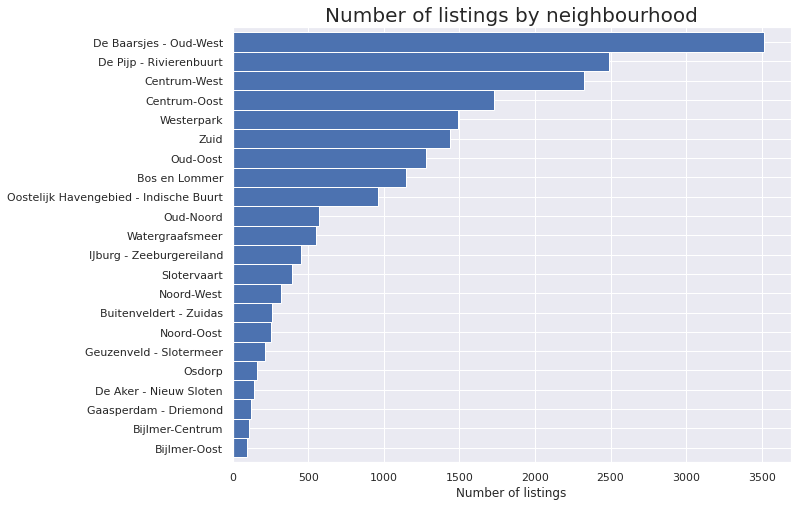

In [11]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

Below, you can see that most listings are in the city centre. This map is interactive, and you can zoom-in on the clusters to eventually find the individual locations of the listings.

Note: In a later version I made a map on the average daily price per neighoudhood. I think this map would also be better at this point (as it uses the neighbourhood shapefile), but as my main goal of this kernel is to learn as much as possible I left the map below unchanged as FastMarkerCluster seems useful for the future.

In [12]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

**Room Types and Property Types**

The room type is very important in Amsterdam, because Amsterdam has a rule that Entire homes/apartments can only be rented out via Airbnb for a maximum of 60 days a year. Below, we can see that this restriction applies to most of the listings.

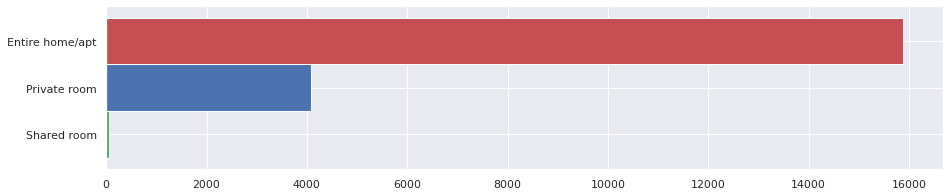

In [13]:
freq = listings['room_type'].value_counts().sort_values(ascending = True)
freq.plot.barh(figsize=(15,3), width=1, color = ['g','b','r'])
plt.show()

**Property Types**

There are many different types of property in our dataset.

In [14]:
listings.property_type.unique()

array(['Apartment', 'Townhouse', 'Houseboat', 'Bed and breakfast', 'Boat',
       'Guest suite', 'Loft', 'Serviced apartment', 'House',
       'Boutique hotel', 'Guesthouse', 'Other', 'Condominium', 'Chalet',
       'Nature lodge', 'Tiny house', 'Hotel', 'Villa', 'Cabin',
       'Lighthouse', 'Bungalow', 'Hostel', 'Cottage', 'Tent',
       'Earth house', 'Campsite', 'Castle', 'Camper/RV', 'Barn',
       'Casa particular (Cuba)', 'Aparthotel'], dtype=object)

However, many of those property types have very few listings in Amsterdam. In the figure below, I am only displaying property types with at least 100 listings. As we can see, the vast majority of the properties in Amsterdam are apartments.

**Accomodates (number of people)**

As expected, most listings are for 2 people. In addition, AirBNB uses a maximum of 16 guests per listing.


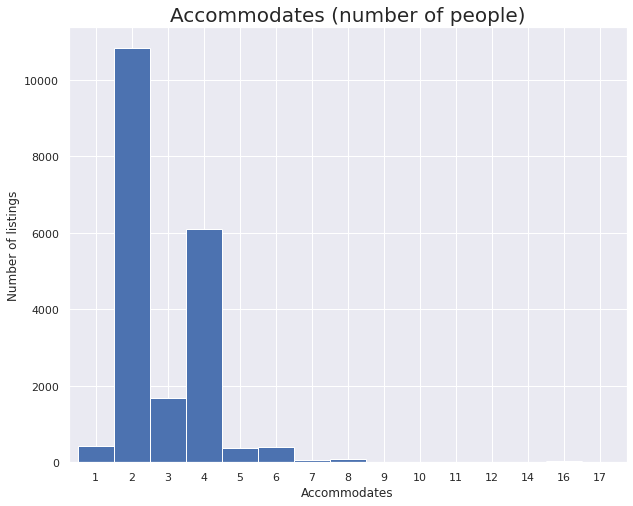

In [16]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

However, Amsterdam has an additional restriction. Due to fire hazard considerations and also taking possible noisy group into account, owners are only allowed to rent their property to groups with a maximum of 4 people. This actually means that the listings that indicate that the maximum number of people is above 4 are breaking this rule!

**Advice to the Municipality of Amsterdam**

It is known that Airbnb causes problems in Amsterdam. These problems are described well in this article: Fed Up With Tourists, Amsterdam Gets Tough On Airbnb, Tourist Taxes And Too Much Partying

The coalition of parties forming the city’s new government wants to follow the examples of Barcelona and Venice, where the flood of unruly tourism has made life extremely unpleasant for residents, forcing officials to try to control the number of visitors and their behavior.

Extra rules that Amsterdam has in place when compared to Airbnb's own rules are:

The maximum number of guests is 4 (see also previous section)
The maximum number for short-term rental is 60 days per calendar year. This rules is only for renting out entire properties, and therefore does not apply to renting out private rooms. This rule was already enforced by Airbnb (after 60 days of bookings, Airbnb closes the availability of the listing for the rest of the year). As you can read in the article, the number will be lowered to a maximum of 30 days a year.
Amsterdam intends to ban Airbnb entirely in three neighourhoods: de Wallen (Red Light District), Kinkerbuurt and Haarlemmerbuurt
For renting out Private Rooms, there is also the restriction that an owner cannot rent-out rooms that accumulate to more than 40% of the total surface (in square meters)



**Finding possibly Illegal Hotels**

Any owner renting out more than 40% of his/her property as Private Rooms is breaking the last rule mentioned in the previous section, but in this section I am only going to look for extreme cases.

Below, I am displaying the five hosts having the most Private Room listings. Unfortunately, Airbnb does not give the addresses of the listings. The field "street" is actually in the database, but as you can see these are certainly not full, real addresses! Therefore, from this table I cannot say if these listings from are in fact in the same house.

In [17]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'street']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,street,private_rooms
2436,67005410,Feliciano,"Amsterdam, Noord-Holland, Netherlands",15
918,10076897,Geraldine,"Amsterdam, Noord-Holland, Netherlands",13
2113,44168250,Ruben,"Amsterdam, Noord-Holland, Netherlands",13
1570,22879651,Wamme,"Amsterdam, Noord-Holland, Netherlands",7
3209,174174070,Amrath,"Badhoevedorp, Badhoevedorp, Netherlands",7


However, we have the GPS-coordinates of the listings. To me, it seems very likely that all private rooms that host Feliciano offers are in fact in the same building (only minor variations in latitude/longitude). Although this host might have a hotel license, his listings seem suspicious too me (what is the name of the hotel?)! I would advise the municipality of Amsterdam to check if no rules are broken in this case.

In [18]:
feliciano = private[private['host_id']==67005410]
feliciano = feliciano[['name', 'host_id', 'host_name', 'latitude', 'longitude']]
feliciano.index.name = "listing_id"
feliciano

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
12392592,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.375251,4.900321
12444222,Hotel in the heart of Amsterdam 4p,67005410,Feliciano,52.375130,4.899694
12446710,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.374695,4.900266
12451293,"Hotel in the heart of Amsterdam, Single room",67005410,Feliciano,52.374682,4.898916
12579177,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.374567,4.898310
12582071,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.373407,4.900022
12865293,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.375077,4.900191
12865495,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.373396,4.898427
12898673,Hotel in the heart of Amsterdam 1p,67005410,Feliciano,52.373346,4.898344


**Unwanted effects of professional hosts?**

At the moment, Amsterdam has no rule in place to prevent professional hosting activities. I can imagine that having the option to outsource these activities leads to even more listings. At the moment, about 75% of the hosts only have one listing. I assume that hosts with just a couple of listings are likely to also be the host for a couple of friends. However, we see that there are extreme cases. I believe that it becomes unlikely that hosts with more than 10 listings are just doing this for themselves and friends and family.

In [20]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,21,24,25,27,30,38,83,105,208
count,15830,1104,174,50,37,24,9,6,4,3,3,3,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1


Below, I diplay the hosts with more that 20 listings. Unfortunately, the host_about is not fully scraped. However as this dataset is extremely recent, it was not hard for me to find the host description of the host with 200+ listings on airbnb.com. As you can see, this host clearly is a professional host!

As it is probably hard to implement and control a measure that completely forbids professional hosting activities, I would advise the municipality of Amsterdam to consider setting a maximum number of listings per host. If Amsterdam would set this at for instance 10 (and manages to get this implemented in Airbnb's systems), it would becomes much harder to exploit hosting at Airbnb as a professional activity

In [21]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

,host_id,host_name,host_about,num_host_listings
8166,65859990,Martijn,"Hi, I'm Martijn, \r\n\r\nWe are a team of prof...",208
535,1464510,Michiel And Jane,"Hi, we are Michiel & Jane,\r\n\r\nWe are a tea...",105
8999,113977564,Willem,I own a hotel in Amsterdam and manage properti...,38
190,517215,Niels En Viv (Welcome Back),"Hi travellers, \r\n\r\nWe are Welcome Back, a ...",30
4935,14183886,Luis,We are Luis and Melanie and we managed our own...,25
4531,11969034,Raul,"Dear Guests,\r\n\r\nI'm Raul, 35 years old. I ...",24
7456,44168250,Ruben,Running a family business in real estate & tou...,21
3457,7594884,"Ruben, Sarah & Lindy","We are Ruben, Sarah & Lindy, we rent out prope...",21


**Advice to tourists**

**Average daily price per neighborhood**

In order to compare "apples to apples" I have only selected the most common type of accommodation, which is accommodation for 2 persons. As expected, accommodation in the city centre is the most expensive.

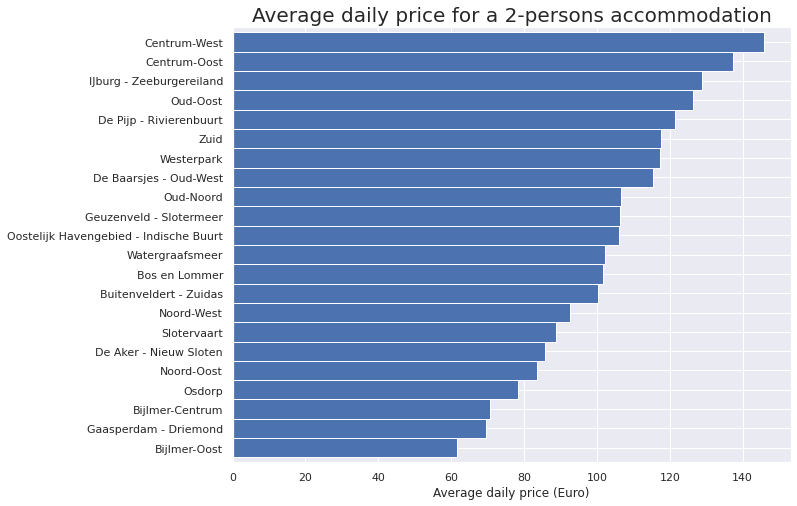

In [22]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

In [23]:
adam = gpd.read_file("/content/Amsterdam_AirBNB/neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

**Review scores location, and location scores versus price**



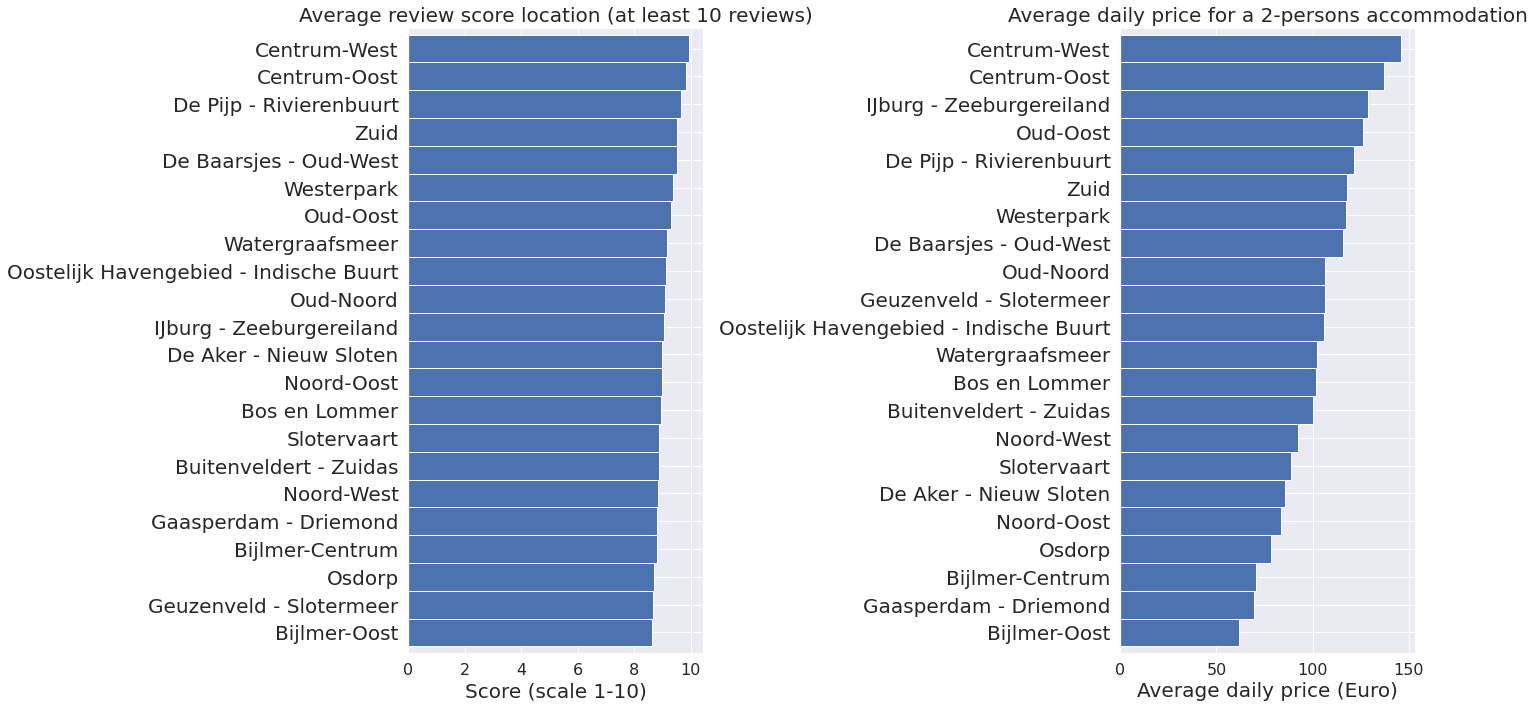

In [24]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

In addition to written reviews, guests can submit an overall star rating and a set of category star ratings. Guests can give ratings on:

Overall Experience. What was your overall experience?

Cleanliness. Did you feel that your space was clean and tidy?

Accuracy. How accurately did your listing page represent your space?

Value. Did you feel your listing provided good value for the price?

Communication. How well did you communicate with your host before and during their stay?

Arrival. How smoothly did their check-in go?

Location. How did you feel about the neighborhood?



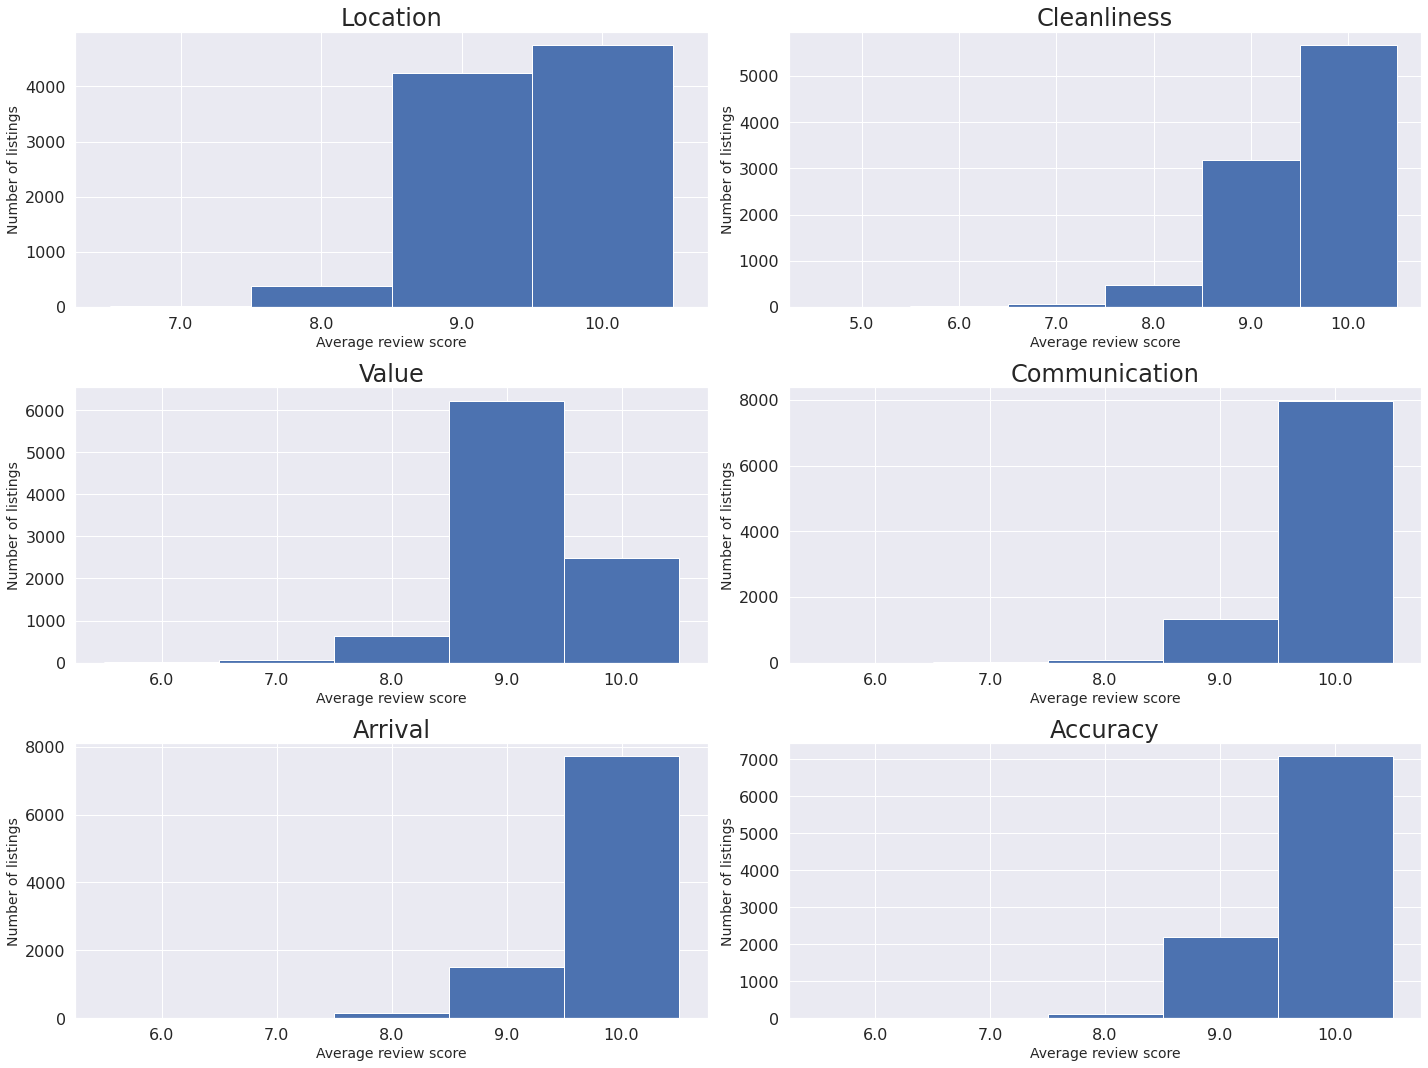

In [25]:
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

**Finding a Good Host**

At Airbnb you can get the status "Superhost". From Airbnb:

As a Superhost, you’ll have more visibility, earning potential, and exclusive rewards. It's our way of saying thank you for your outstanding hospitality.
How to become a Superhost: Every 3 months, we check if you meet the following criteria. If you do, you'll earn or keep your Superhost status.
Superhosts have a 4.8 or higher average overall rating based on reviews from at least 50% of their Airbnb guests in the past year.
Superhosts have hosted at least 10 stays in the past year or, if they host longer-term reservations, 100 nights over at least 3 stays.
Superhosts have no cancellations in the past year, unless there were extenuating circumstances.
Superhosts respond to 90% of new messages within 24 hours.
Below, we can see that only a small portion of the listings in Amsterdam do have a host who is Superhost.


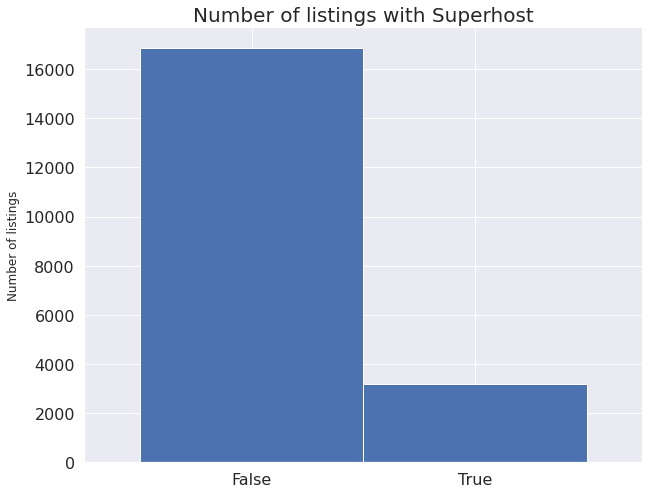

In [26]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

As we can see, over 5,000 of the 20,000 listings have at least 10 reviews and respond to at least 90% of the new messages. I would consider those hosts "proven" good responders (which does not mean that a listing with less than 10 reviews cannot have good responding hosts; it is just not proven yet). Also, there are very few listings with hosts not replying to new messages within 24 hours.

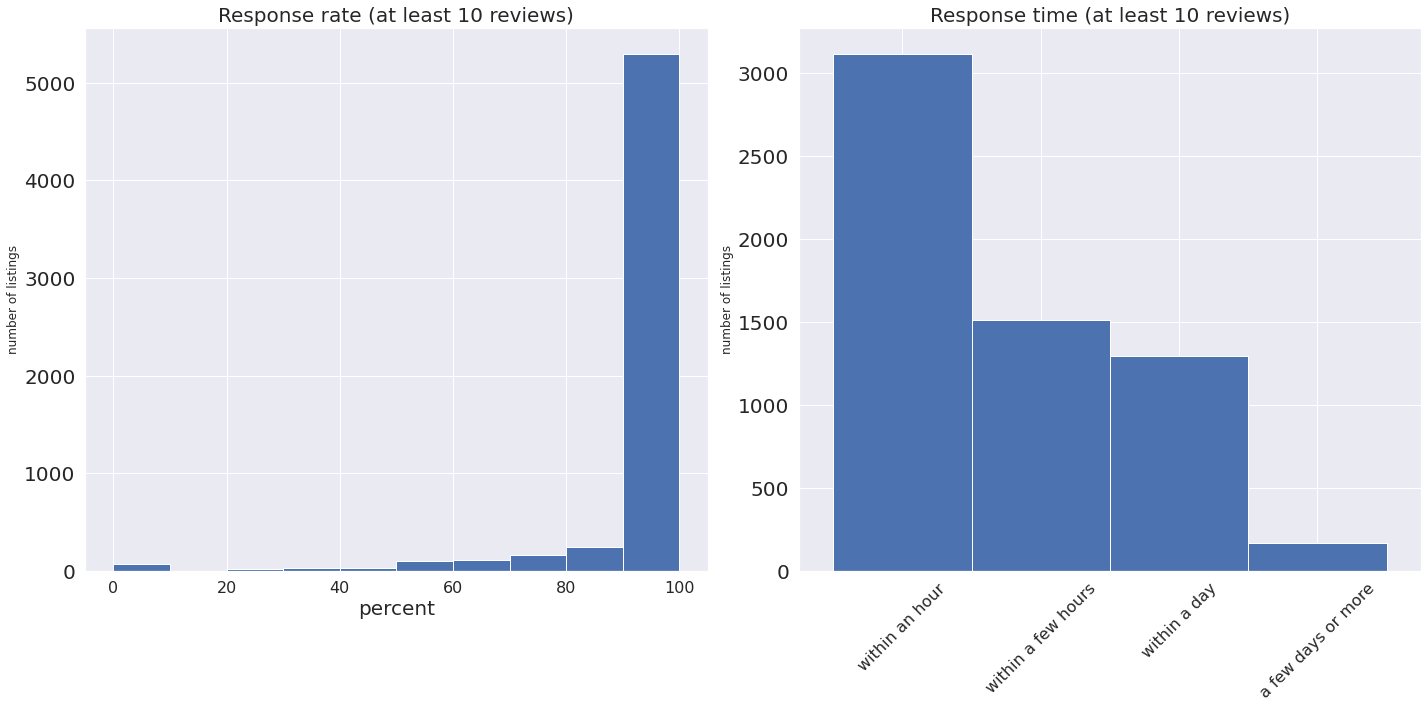

In [27]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

**Availability over Time**

The calendar file holds 365 records for each listing, which means that for each listing the price and availablity by date is specified 365 days ahead.

In [28]:
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2019-12-05']

In [29]:
print(calendar.shape)

(7290073, 3)


A sample of the calendar data is shown below. Important to note: availability is FALSE means that either the owner does not want to rent out his property on the specific date, or the listing has been booked for that date already. As I want to compare apples-to-apples again regarding the prices in the next section, I am merging the 'accomodates' variable with the calendar.

In [30]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,accommodates
listing_id,,,,
5940213,2018-12-26,f,NaN,2
29325099,2018-12-27,t,450.0,4
4150731,2019-07-23,f,NaN,2
8493516,2019-03-13,f,NaN,2
23394883,2018-12-20,f,NaN,2
10441222,2019-04-26,t,90.0,2
29503926,2019-07-06,f,NaN,2
28180199,2019-10-03,f,NaN,2
22028962,2019-07-19,f,NaN,1


In [31]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date')

**Average Price by Date**

Below, you see the average price of all 2-persons accomodations flagged as available by date. The peak of average price 240 Euro is at December 31st, and the cyclical pattern is due to higher prices in weekends. However, I suspect that prices for dates further ahead in time are mostly not updated yet and are probably default prices. This might result in a booking not being accepted by the host if the host realizes that someone is trying to book something on a date that should have been more expensive than usual. This graph is interactive, and hovering over the points will show you a tooltip with the average price and weekday by date.

In [34]:
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
    text='weekday', title='Average price of available 2 persons accommodation by date')

**Text mining the Review comments**

In [33]:
reviews_details.shape

(431830, 6)

In [35]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
1191,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1771,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
1989,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
2797,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
3151,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [36]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

,,number_of_reviews
host_id,host_name,
1464510,Michiel And Jane,1772
65859990,Martijn,1407
67005410,Feliciano,1350
336950,Manuel,1154
124245,Edwin,1001


In [37]:
reviews_details.comments.head()

id
1191    Daniel is really cool. The place was nice and ...
1771    Daniel is the most amazing host! His place is ...
1989    We had such a great time in Amsterdam. Daniel ...
2797    Very professional operation. Room is very clea...
3151    Daniel is highly recommended.  He provided all...
Name: comments, dtype: object

In [38]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

'We had such a great time in Amsterdam. Daniel is an excellent host! Very friendly and everytime helpful. The room was cozy, comfortable, and VERY clean. Maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. Bathroom with all the bathroom requires. Good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.\r\nTotally recommendable! '

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'great time amsterdam daniel excellent host friendly everytime helpful room cozy comfortable clean maps towels mini fridge coffee very tasty tea supplies provided bathroom bathroom requires good location next tram stop took around minutes get city center totally recommendable '

In addition to removing the stopwords, I also wanted to remove the host names. However the list of host names contains over 5,000 words, and removing those takes a long time. Therefore, I am not removing them yet at this point.

In [42]:
host_names = reviews_details[['host_name']].drop_duplicates()
host_names = host_names.host_name.str.lower().tolist()

# reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
#                                                       if i not in (host_names)]))

len(host_names)

5481

In [43]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
51,great,203591
175,apartment,183343
53,amsterdam,171791
87,stay,164215
3,place,161435
106,us,130859
4,nice,123083
67,location,119437
26,host,102330
5,clean,94514


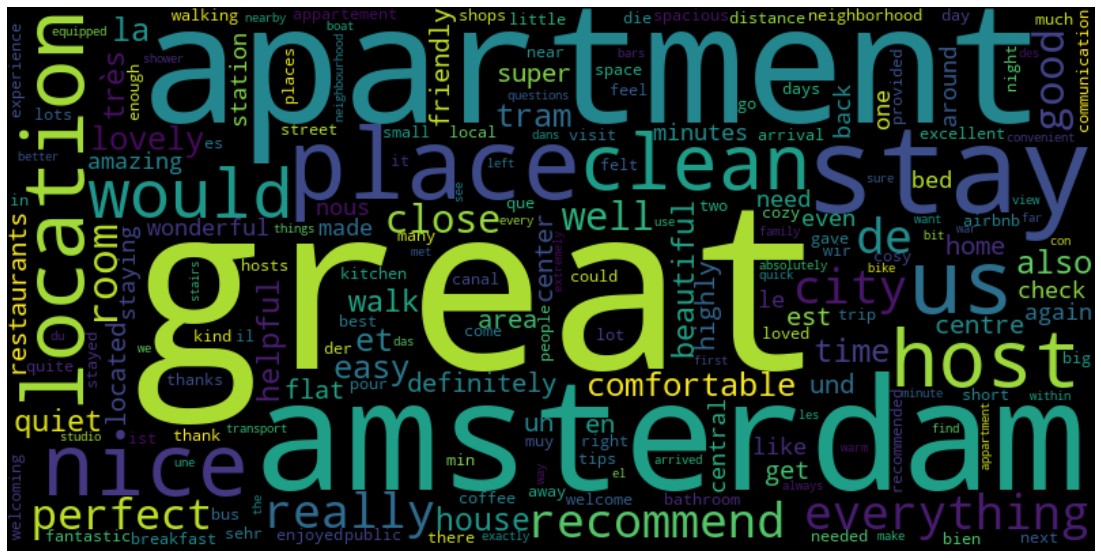

In [45]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()